In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cmath import nan
import os
import re
import numpy as np 
import pandas as pd
import math
import click
import json

from pymatgen.core import Structure

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ch4_sigma , ch4_epsilon = 3.73, 148
c_sigma, c_epsilon = 2.8, 27.0
o_sigma, o_epsilon = 3.05, 79.0
uff = pd.read_csv("./ff_data/uff.csv")

In [4]:
threshold = 15

In [5]:
nvt_path = "./nvt_results"
rst_path = "./parse_results_co2"

In [6]:
structure_lst = os.listdir(nvt_path)
structure_lst

['ABETIN_clean', 'ABUWOJ_clean', 'ABEXEN_clean']

In [7]:
structure = structure_lst[2]

# Data preparation

## Get supercell

In [8]:
def get_supercell(structure):
    with open("nvt_results/%s/simulation.input" %structure, "r") as f_input:
        for line in f_input:
            if re.search("UnitCells", line):
                s1, s2, s3 = line.split()[1], line.split()[2], line.split()[3]
    supercell = [int(s1), int(s2), int(s3)]
    return supercell

In [9]:
sc = get_supercell(structure)

In [10]:
sc

[2, 2, 1]

## Get lattice

In [11]:
def get_lattice(structure):
    with open("nvt_results/%s/Movies/System_0/Framework_final.pdb" %structure) as file:
        lines = file.readlines()
        lattice = [float(l) for l in lines[1].split()[1:4]]
        frame_ele = [l.split()[2] for l in lines[2:]]
        frame_pos = [np.array([float(t) for t in l.split()[4:7]]) for l in lines[2:]]
    return lattice, frame_ele, frame_pos

In [12]:
latt, ele, pos = get_lattice(structure)

In [13]:
latt

[50.196, 50.196, 28.446]

In [14]:
len(ele)

1920

# read gas pos

In [14]:
with open(os.path.join(nvt_path, "%s/Movies/System_0/Movie_%s_%d.%d.%d_298.000000_0.000000_allcomponents.pdb" %(structure, structure, sc[0], sc[1], sc[2]))) as file:
        data = file.readlines()
        positions = [line.split() for line in data if "ATOM" in line]
        pos_c = [np.array([float(t) for t in l[4:7]]) for l in positions if l[1] == '2']
        pos_o1 = [np.array([float(t) for t in l[4:7]]) for l in positions if l[1] == '1']
        pos_o2 = [np.array([float(t) for t in l[4:7]]) for l in positions if l[1] == '3']
    

# calculate distance

In [15]:
dist_c = np.array([np.abs([atom-c for atom in pos]) for c in pos_c])

In [16]:
dist_c_un = np.array([[[l-r if r>l/2 else r for r,l in zip(a, latt)] for a in s] for s in dist_c])

In [17]:
dist_c_un.shape

(10000, 1920, 3)

In [18]:
distance_c = np.array(
    [[np.sqrt(np.sum([r**2 for r in a])) for a in s] for s in dist_c_un]
)

(array([ 638313.,  928030., 1252501., 2235278., 2701079., 3327048.,
        4199892., 2688127., 1063286.,  166446.]),
 array([ 2.47100809,  6.04542899,  9.61984989, 13.19427079, 16.76869169,
        20.34311258, 23.91753348, 27.49195438, 31.06637528, 34.64079618,
        38.21521707]),
 <BarContainer object of 10 artists>)

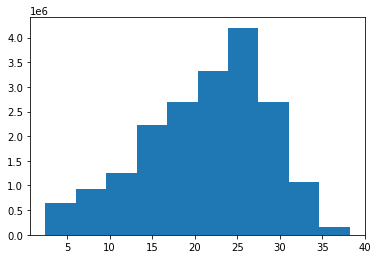

In [ ]:
plt.hist(distance_c.flatten())

In [19]:
dist_o1 = np.array([np.abs([atom-o for atom in pos]) for o in pos_o1])
dist_o1_un = np.array([[[l-r if r>l/2 else r for r,l in zip(a, latt)] for a in s] for s in dist_o1])
distance_o1 = np.array(
    [[np.sqrt(np.sum([r**2 for r in a])) for a in s] for s in dist_o1_un]
)

In [20]:
dist_o2 = np.array([np.abs([atom-o for atom in pos]) for o in pos_o2])
dist_o2_un = np.array([[[l-r if r>l/2 else r for r,l in zip(a, latt)] for a in s] for s in dist_o2])
distance_o2 = np.array(
    [[np.sqrt(np.sum([r**2 for r in a])) for a in s] for s in dist_o2_un]
)

## Read force field

### Read ff with LB mixing rule

In [21]:
uff = pd.read_csv("ff_data/uff.csv")

In [22]:
uff

,Unnamed: 0,element,epsilon,sigma,lb_sigma,lb_epsilon
0,0,Ac,16.6080,3.0985,3.399618,82.30400
1,1,Ag,18.1178,2.8045,3.234314,83.05890
2,2,Al,254.1520,4.0082,3.866599,201.07600
3,3,Am,7.0458,3.0121,3.351885,77.52290
4,4,Ar,93.1052,3.4460,3.585189,120.55260
...,...,...,...,...,...,...
98,98,Xe,167.0861,3.9235,3.825527,157.54305
99,99,Y,36.2355,2.9801,3.334033,92.11775
100,100,Yb,114.7458,2.9890,3.339007,131.37290
101,101,Zn,62.4056,2.4616,3.030143,105.20280


In [23]:
ele_sigma = [uff[uff["element"]==e]["sigma"].item() for e in ele]
ele_epsilon = [uff[uff["element"]==e]["epsilon"].item() for e in ele]

In [24]:
ele_sigma_c = [(uff[uff["element"]==e]["sigma"].item()+c_sigma)/2 for e in ele]
ele_epsilon_c = [np.sqrt(uff[uff["element"]==e]["epsilon"].item()*c_epsilon) for e in ele]

In [25]:
ele_sigma_o = [(uff[uff["element"]==e]["sigma"].item()+o_sigma)/2 for e in ele]
ele_epsilon_o = [np.sqrt(uff[uff["element"]==e]["epsilon"].item()*o_epsilon) for e in ele]

# Calculate potentials

In [26]:
poten_c = np.array([ele_epsilon_c*((ele_sigma_c/r)**6-(ele_sigma_c/r)**12) for r in distance_c])

(0.0, 100.0)

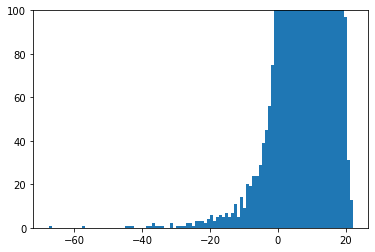

In [32]:
plt.hist(poten_c.flatten(), bins=100)
plt.ylim(0,100)

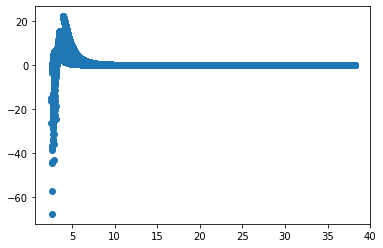

In [33]:
plt.scatter(distance_c, poten_c)

In [27]:
avg_poten_c = np.average(poten_c, axis=0)

In [28]:
plt.hist(avg_poten, bins=100)

NameError: name 'avg_poten' is not defined

## sum potential for C and O

In [29]:
poten_o1 = np.array([ele_epsilon_o*((ele_sigma_o/r)**6-(ele_sigma_o/r)**12) for r in distance_o1])
poten_o2 = np.array([ele_epsilon_o*((ele_sigma_o/r)**6-(ele_sigma_o/r)**12) for r in distance_o2])

In [30]:
avg_poten_o1 = np.average(poten_o1, axis=0)
avg_poten_o2 = np.average(poten_o2, axis=0)

In [31]:
avg_poten = np.array([-(c+o1+o2) for c, o1, o2 in zip(avg_poten_c, avg_poten_o1, avg_poten_o2)])

(array([  2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   2.,   3.,   1.,   1.,   2.,   0.,   0.,   2.,
          1.,   0.,   0.,   0.,   0.,   3.,   4.,   4.,   0.,   2.,   2.,
          4.,   4.,   3.,   2.,   5.,   6.,   2.,   4.,   6.,   6.,   4.,
          9.,   5.,   7.,  14.,  13.,  17.,  13.,  12.,  36.,  25.,  40.,
         42.,  44.,  44.,  59.,  85.,  93.,  80., 163., 180., 281., 276.,
        300.]),
 array([-7.18166243, -7.11007772, -7.03849302, -6.96690831, -6.89532361,
        -6.8237389 , -6.7521542 , -6.68056949, -6.60898479, -6.53740008,
        -6.46581538, -6.39423067, -6.32264597, -6.25106126, -6.17947655,
        -6.10789185, -6.03630714, -5.96472244, -5.89313773, -5.82155303,
        -5.74996832, -5.67

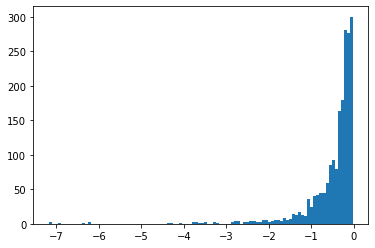

In [32]:
plt.hist(avg_poten, bins=100)

# potential normalization

## map avg_potential to one unit cell

In [33]:
num_uc = sc[0] * sc[1] * sc[2]
num_at = int(len(pos) / num_uc)

In [34]:
for i in range(num_uc):
    if i == 0:
        poten_uc = avg_poten[0:num_at]
    else:
        poten_uc += avg_poten[i*num_at:(i+1)*num_at]
poten_uc /= num_uc

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
poten_norm = scaler.fit_transform(poten_uc.reshape(-1, 1))

(array([ 2.,  0.,  0.,  1.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  4.,  4.,
         4.,  0.,  3.,  0.,  0.,  2.,  2.,  5.,  3.,  3.,  5.,  5., 10.,
         6.,  4.,  3.,  5., 10., 10.,  7.,  8., 23., 10., 17.,  3.,  6.,
        27., 25., 18., 26., 52., 36., 32., 29., 58.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

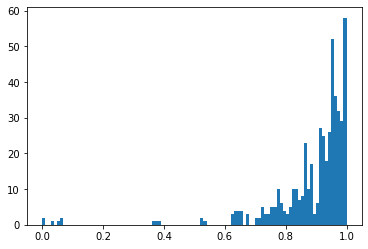

In [37]:
plt.hist(poten_norm, bins=100)

# Visulization

In [38]:
from ase_notebook import AseView, ViewConfig

In [39]:
cif = Structure.from_file("nvt_results/%s/%s.cif" %(structure, structure))

In [40]:
cif.add_site_property("weight", poten_norm.reshape(-1,))

In [41]:
config = ViewConfig()
config.atom_font_size=10
config.axes_length=30
config.canvas_size=(500, 500)
config.zoom=1.2
config.show_bonds=True
config.atom_color_by = "value_array"
config.atom_color_array = "weight"
config.atom_colormap = "Greens"
config.atom_colormap_range = (0, 1)

In [42]:
ase_view = AseView(config)
gui = ase_view.make_render(
    cif, center_in_uc=True)
gui

get_element_radii


/home/xiaoqi/anaconda3/envs/ml/lib/python3.7/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 266.1132862165919), p…

In [ ]:
distance_c.shape